
### what - the goal
of this notebook is to do live plot word2vec loss.

### why 
to debug the model.

### how 
use word2vec callback function.


# import libs needed

In [1]:
# live plot
!pip install livelossplot 
from livelossplot import PlotLosses

plotlosses = PlotLosses()

# define the callback

In [2]:
from gensim.models.callbacks import CallbackAny2Vec
import os
import math
import sys
from datetime import datetime
import psutil  
import numpy as np

def sys_stats():
    pid = os.getpid()
    ps = psutil.Process(pid)
    memory_usage = ps.memory_info()[0] / 2. ** 30
    return 'memory usage GB:' + str(np.round(memory_usage, 2))

class w2vcallback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
  
    def __init__(self):
        self.epoch = 0
        self.loss_last = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        # define your own calculation of the loss
        loss_now = loss - self.loss_last
        self.loss_last = loss
        self.epoch += 1
        print(f'Loss after epoch {self.epoch}: {loss_now}')   
        plotlosses.update({    
           'loss': loss_now, ### / (epoch + 2.),
        })
        plotlosses.send()


In [3]:
!pip install polars
import gc
import polars as pl
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

train = pl.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')
test = pl.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 35.2 MB/s eta 0:00:00


In [4]:
sentences_df =  pl.concat([train, test]).groupby('session').agg(
    pl.col('aid').alias('sentence')
)

sentences = sentences_df['sentence'].to_list()
del sentences_df; gc.collect() 

0

# chain the callback to word2vec

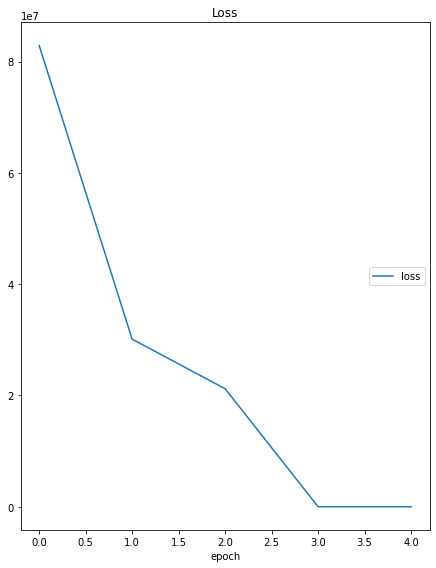

Loss
	loss             	 (min:    0.000, max: 82896536.000, cur:    0.000)
CPU times: user 6h 5min 50s, sys: 35.4 s, total: 6h 6min 25s
Wall time: 1h 36min 25s


In [5]:
%%time

#w2vec = Word2Vec(sentences=sentences, vector_size= 64, window = 3, negative = 8, ns_exponent = 0.2, sg = 1, min_count=1, workers=4)
num_of_vecs = 64
min_count_events_per_session = 1

w2vec = Word2Vec(sentences, vector_size=num_of_vecs, min_count=min_count_events_per_session, workers=4, 
                 sg = 1, negative = 8, ns_exponent = 0.2,
                 window=3, compute_loss=True, callbacks=[w2vcallback()])
    

In [6]:
%%time

from annoy import AnnoyIndex

aid2idx = {aid: i for i, aid in enumerate(w2vec.wv.index_to_key)}
index = AnnoyIndex(64, 'euclidean')

for aid, idx in aid2idx.items():
    index.add_item(idx, w2vec.wv.vectors[idx])
    
index.build(32)

CPU times: user 2min 47s, sys: 1.76 s, total: 2min 49s
Wall time: 53.5 s


True

In [7]:
import pandas as pd
import numpy as np

from collections import defaultdict
import collections

session_types = ['clicks', 'carts', 'orders']
test_session_AIDs = test.to_pandas().reset_index(drop=True).groupby('session')['aid'].apply(list)
test_session_types = test.to_pandas().reset_index(drop=True).groupby('session')['type'].apply(list)

In [8]:
labels = []

type_weight_multipliers = {0: 1, 1: 6, 2: 3}

session_num = len(test_session_AIDs)

for AIDs, types in zip(test_session_AIDs[:session_num], test_session_types[:session_num]):
    if len(AIDs) >= 20:
        # if we have enough aids (over equals 20) we don't need to look for candidates! we just use the old logic
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
        aids_temp=defaultdict(lambda: 0)
        for aid,w,t in zip(AIDs,weights,types): 
            aids_temp[aid]+= w * type_weight_multipliers[t]
            
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
        labels.append(sorted_aids[:20])
    else:
        # here we don't have 20 aids to output -- we will use word2vec embeddings to generate candidates!
        AIDs = list(dict.fromkeys(AIDs[::-1]))
        
        # let's grab the up to 3 recent aids
        recent_len = max(min(3,len(AIDs)),1)
        
        # how many aids for each aid
        AIDs_num = round((20-len(AIDs))/recent_len) + 2
        
        # let's look for some neighbors!        
        nns_it = []
        for it in range(0,recent_len):
            nns_it += [w2vec.wv.index_to_key[i] for i in index.get_nns_by_item(aid2idx[AIDs[it]], AIDs_num)[1:]]
        
        # select repeating and unique neighbors
        nns_repeated = [item for item, count in collections.Counter(nns_it).items() if count > 1]
        nns_once = [item for item, count in collections.Counter(nns_it).items() if count == 1]

        # prepare selection
        nns = (nns_repeated+nns_once)[:20]
        labels.append((AIDs+nns)[:20])

In [9]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

del labels, labels_as_strings, predictions, prediction_dfs
gc.collect()

0

In [10]:
submission.head()


,session_type,labels
0,12899779_clicks,59625 448688 345122 231004 509607 819821 10658...
1,12899780_clicks,1142000 736515 973453 582732 1360606 487136 15...
2,12899781_clicks,918667 199008 194067 57315 141736 1836671 1228...
3,12899782_clicks,834354 595994 740494 889671 987399 779477 1344...
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 ...


# note
other sections of code are based on @Word2vec model [training and submission | 0.533]
